# Analysis and Visualization of Sinopia Graphs

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%reload_ext lab_black

import json

import rdflib
import requests
import kglab
import helpers
import widgets

## PCC BIBFRAME Work-Instance-Item Graph
We can use [Sinopia API](https://github.com/ld4p/sinopia_api) to construct a small RDF graph made up of a [BIBFRAME](https://bibframe.org/) Work, Instance, and Item resources and then create a knowledge graph for analysis and visualization of the entities along with their properties.

### Step One: Identify Sinopia URLs
First we will download the following resources from Sinopia's stage environment and then parse the RDF
contained in the resulting JSON.

- **BIBFRAME Work**: https://api.stage.sinopia.io/resource/6861fc10-0213-4dfc-b1a0-7df975d235dd
- **BIBFRAME Instance**: https://api.stage.sinopia.io/resource/986d673d-f006-44ab-8bf7-b92b279fddfa
- **BIBFRAME Item**: https://api.stage.sinopia.io/resource/6767bae3-ee42-4179-8b58-2f3791cb1a6b

In [2]:
sinopia_stage_urls = [
    "https://api.stage.sinopia.io/resource/6861fc10-0213-4dfc-b1a0-7df975d235dd",
    "https://api.stage.sinopia.io/resource/986d673d-f006-44ab-8bf7-b92b279fddfa",
    "https://api.stage.sinopia.io/resource/6767bae3-ee42-4179-8b58-2f3791cb1a6b",
]

### Step Two: Create RDF Namespaces and Graph

Here we create two namespaces for the BIBFRAME and Sinopia vocabularies and bind them to the new Sinopia graph.

In [3]:
BIBFRAME = rdflib.Namespace("http://id.loc.gov/ontologies/bibframe/")
SINOPIA = rdflib.Namespace("http://sinopia.io/vocabulary/")

sinopia_pcc_graph = rdflib.Graph()
sinopia_pcc_graph.namespace_manager.bind("bf", BIBFRAME)
sinopia_pcc_graph.namespace_manager.bind("sinopia", SINOPIA)

### Step Three: Download and Parse RDF into the Graph

We now loop through all of the URLs in the list of Sinopia URLs, query the Sinopoia Stage API endpoint for these resources, and add the JSON-LD to the graph.

In [4]:
print(f"Starting triples in our RDF graph {len(sinopia_pcc_graph)}")
for sinopia_url in sinopia_stage_urls:
    api_result = requests.get(sinopia_url)
    if api_result.status_code < 300:
        resource_json = api_result.json()
        # Need to serialize the JSON to a string for parsing
        sinopia_pcc_graph.parse(
            data=json.dumps(resource_json["data"]), format="json-ld"
        )
    else:
        print(
            f"ERROR {api_result.status_code} for {sinopia_url}\nDetail {api_result.text}"
        )
print(f"Finished ingesting resources, size of graph {len(sinopia_pcc_graph)}")

Starting triples in our RDF graph 0
Finished ingesting resources, size of graph 127


### Step Four: Create a Knowledge Graph

Now that we have our BIBFRAME Work, Instance, and Items parsed into our RDF graph, we will then create a knowledge graph.

In [5]:
sinopia_bf_kg = kglab.KnowledgeGraph(
    name="Sinopia Stage PCC Knowledge Graph", import_graph=sinopia_pcc_graph
)

### Step Five: Basic Graph Analysis

Our simple PCC BIBFRAME Knowledge Graph provides a number of methods that allow us to analyze the shape and structure RDF through a "graph" lens. 

In graph terminology, a **Node** is the fundamental unit and is represented in RDF:
- By a URI or blank-node in the *subject* role 
- By a URI, blank-node, or Literal in the *object* role. 

An **Edge** is a linkage between two nodes. In RDF, the *predicate* is edge connecting the *subject* with the *object*. 
Because the order in triple matters, RDF is know as a directed graph.

In [6]:
measure = kglab.Measure()
measure.measure_graph(sinopia_bf_kg)
print("Edges: {:,}\n".format(measure.get_edge_count()))
print("Nodes: {:,}\n".format(measure.get_node_count()))

Edges: 127

Nodes: 67



We can confirm that the number of edges in our PCC BIBFRAME graph is equal to the number of predicates by creating a list of all of the predicates and then calculate the number of members in that list using the builtin Python `len` function.

In [7]:
predicates = [p for p in sinopia_pcc_graph.predicates()]
print(
    f"""Total number of predicates: {len(predicates)}, 
         Test for equality: {len(predicates) == measure.get_edge_count()}"""
)

Total number of predicates: 127, 
         Test for equality: True


## Exercise 1: Create a Sinopia BIBFRAME Knowledge Graph
Using any of the three Sinopia environments (development, stage, or production), find a BIBFRAME Work with a corresponding BIBFRAME Instance and then replicate the steps above to create a Sinopia BIBFRAME Knowledge Graph.

# Visualization of the PCC BIBFRAME Graph

In [8]:
sinopia_pcc_subgraph = kglab.SubgraphTensor(sinopia_bf_kg)
pyvis_graph = sinopia_pcc_subgraph.build_pyvis_graph(notebook=True)
pyvis_graph.force_atlas_2based()
pyvis_graph.show("pcc_bf.fig01.html")

<hr>

# Sinopia Stage Graph Analysis and Visualizations
First we will load the saved knowledge graph and then will do similar analysis on the entire Sinopia stage graph.

In [23]:
stage_kg = kglab.KnowledgeGraph()
stage_kg.load_jsonld("data/stage.json")
print(f"Total triples {len(stage_kg.rdf_graph()):,}")

Total triples 138,391


First let see how many edges and nodes are in all of the resources in Sinopia stage:

In [24]:
stage_measure = kglab.Measure()
stage_measure.measure_graph(stage_kg)

In [25]:
print("Edges: {:,}\n".format(stage_measure.get_edge_count()))
print("Nodes: {:,}\n".format(stage_measure.get_node_count()))

Edges: 138,391

Nodes: 40,562



## Visualization using Pandas DataFrames

With our stage knowledge graph, we can query our graph with SPARQL and return the results as a Panda's DataFrame. DataFrames offer a number of built-in graphs that can be useful for summarizing or visualizing information about the RDF.

To start, we'll query the graph to get all of the RDF classes of entities.

In [12]:
classes_df = stage_kg.query_as_df(
    """
SELECT ?class
WHERE {
  ?url rdf:type ?class .
}
"""
)

With the Pandas `classes_df` dataframe, we can see how many classes are in Sinopia stage environment by using the `.info()` method:

In [16]:
classes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27691 entries, 0 to 27690
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   27691 non-null  object
dtypes: object(1)
memory usage: 216.5+ KB


Using the `.head()` method, display the first five rows in the dataframe:

In [19]:
classes_df.head()

,class
0,sinopia:UriPropertyTemplate
1,sinopia:UriPropertyTemplate
2,sinopia:UriPropertyTemplate
3,sinopia:UriPropertyTemplate
4,sinopia:UriPropertyTemplate


Finally, we can display a random sample of RDF classes in `classes_df` with the `sample()` method:

In [20]:
classes_df.sample(10)

,class
3368,sinopia:PropertyTemplate
26015,bf:Print
17128,bf:Person
16617,bf:Instance
25956,bf:Print
27184,bf:Manufacture
15425,bf:AdminMetadata
18962,sinopia:ResourcePropertyTemplate
24814,bf:VariantTitle
27281,bf:AspectRatio


To generate a count of each RDF classes use the `.value_counts()` method and display the top 36 RDF classes with the slice notation `[0:35]`:

In [13]:
classes_df["class"].value_counts()[0:35]

sinopia:PropertyTemplate                                           4073
bf:AdminMetadata                                                   1672
bf:Title                                                           1467
sinopia:ResourcePropertyTemplate                                   1439
bf:Note                                                            1199
sinopia:LookupPropertyTemplate                                     1131
bf:Agent                                                           1100
bf:Work                                                             984
bf:Person                                                           837
bf:Contribution                                                     827
<https://w3id.org/arm/core/ontology/0.1/Citation>                   738
sinopia:ResourceTemplate                                            693
bf:Instance                                                         656
bf:Status                                                       

To generate a bar chart of these values, we call the `.plot` method on the previous `value_counts`  and 
display the results:

<AxesSubplot:>

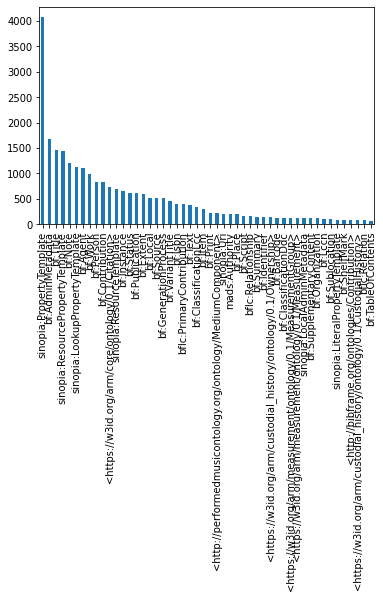

In [22]:
classes_df["class"].value_counts()[0:35].plot(kind="bar")